# Summary of Analysis

In [1]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/08 00:00:52 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.30.150.64 instead (on interface eth0)
22/10/08 00:00:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 00:00:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pandas as pd
import re

# Reading raw data


In [3]:
#read internal tables

#dataframes: transaction_sample, merchants_tbl, customer_tbl  

transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample = transactions_sample.unionByName(transactions_sample2, True)
transactions_sample = transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# parse "tag" of merchants

In [4]:
merchants_pd = merchants_tbl.toPandas()
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants_pd['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [5]:
merchant_tag= pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchants_pd = pd.concat([merchants_pd, merchant_tag], axis=1)
# drop the tags column 
merchants_pd.drop(columns='tags', inplace=True)

# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchants_pd)

# Join all the internal datasets

In [6]:
# First lets look at the number of registered customers and merchants without any data in the dataset
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])
full_dataset = transactions_sample.join(customer_tbl, on = ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])
full_dataset.createOrReplaceTempView('full')
full_dataset.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Earnings_Class: string (nullable = true)
 |-- BNPL_Fee: double (nullable = true)



In [7]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

In [8]:
# Compare difference in records between joined table and raw data
full = full_dataset.count()
raw = transactions_sample.count()
print(f'Joined count: {full}, raw count: {raw}, difference {raw - full} or {round(100 * ((raw - full) / raw), 2)}%')

Joined count: 13614675, raw count: 14195505, difference 580830 or 4.09%


# number of transactions without valid merchants abns in the merchants table

In [9]:
# First lets look at the number of transactions without valid merchants abns in the merchants table
merchants_tbl.createOrReplaceTempView('merchants')
customer_tbl.createOrReplaceTempView('consumer')
transactions_sample.createOrReplaceTempView('trans')
missing = spark.sql("""
select count(*) from trans
where trans.merchant_abn not in (select merchant_abn from merchants)
""")
print("the number of transactions without valid merchants abns in the merchants table: ")
print(missing.head()[0])

print("percentage of all transactions:")
print(missing.head()[0]/transactions_sample.count())

the number of transactions without valid merchants abns in the merchants table: 


580830
percentage of all transactions:


0.040916473207539994


# Key finding 1 - Quantity vs Quality

In [ ]:
real_full_dataset = spark.read.parquet('../data/curated/full_dataset/')

In [11]:
real_full_dataset.limit(10)

22/10/08 00:02:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


order_id,merchant_abn,user_id,dollar_value,order_datetime,consumer_id,state,postcode,name,address,gender,sa3name,sa4name,electoraterating,SA3_NAME_2016,electorate,Number of individuals lodging an income tax return,Average taxable income or loss,Median taxable income or loss,Proportion with salary or wages,Count salary or wages,Average salary or wages,Median salary or wages,Proportion with net rent,Count net rent,Average net rent,Median net rent,Average total income or loss,Median total income or loss,Average total deductions,Median total deductions,Proportion with total business income,Count total business income,Average total business income,Median total business income,Proportion with total business expenses,Count total business expenses,Average total business expenses,Median total business expenses,Proportion with net tax,Count net tax,Average net tax,Median net tax,Count super total accounts balance,Average super total accounts balance,Median super total accounts balance,Total_Transaction_Count,Total_Dollars_Spent,Ungeristered_Merch_Transactions_count,Ungeristered_Merch_Total_Spent,Proportion_Unreg_Merchant_Transactions,Proportion_Unregistered_Dollars_Spent,company_name,Description,Earnings_Class,BNPL_Fee,Day,Month,BNPL_Revenue,Natural_var,Potential_Outlier
00001f53-b987-4b4...,31585975447,8913,51.28,2021-07-24,1656,NSW,1163,Timothy Guzman,061 Randall View,Male,Sydney Inner City,Sydney - City and...,Rural,Sydney Inner City,Sydney,16556,59451,44127,1,12283,66835,56122,1,4466,-2167,-1652,61594,46090,2085,544,1,1711,137729,27024,1,1578,123193,10546,1,11634,19453,12318,17185,142962,42522,580,122452.95,21,3632.51,0.04,0.03,Dolor Dapibus Gra...,4020,b,3.12,7,7,1.6,false,false
00004dfd-5e01-408...,21025433654,15797,5.84,2021-11-26,497662,WA,6228,Michael Leblanc,02118 Goodwin Ferry,Male,Bunbury,Bunbury,Rural,Bunbury,Forrest,5933,59563,46555,1,4710,59602,50964,1,893,1060,275,62473,48886,2592,604,1,583,93052,31586,1,548,74939,18585,1,4540,18198,11010,6658,150130,57634,585,96815.18,25,4359.86,0.04,0.05,Lorem Foundation,4020,a,6.55,6,11,0.38,false,false
0000a01b-53f2-4f6...,91923722701,4694,0.36,2022-05-07,681639,NSW,2158,Lisa Cole,70976 Steve Flats,Female,Dural - Wisemans ...,Sydney - Baulkham...,Outer Metropolitan,Dural - Wisemans ...,Berowra,1397,60643,52180,1,1051,66838,59969,1,218,1865,633,63628,54513,2587,677,1,174,111167,43737,1,170,101982,39102,1,1066,17584,12605,1458,155461,77116,570,90094.33,22,8730.59,0.04,0.1,Euismod Urna Inst...,3988,b,5.05,7,5,0.02,false,false
0000b108-2dfa-488...,40646162173,3260,5.72,2022-04-18,643439,WA,6155,Jennifer Austin,1762 Kathryn Over...,Female,Melville,Perth - South West,Inner Metropolitan,['Canning' 'Gosne...,Tangney,4406,50928,43102,1,3486,55030,48742,1,618,1080,355,53756,45367,2410,551,1,404,92048,31611,1,386,80450,21617,1,3339,14932,9652,4992,132876,53654,559,95079.05,18,6813.46,0.03,0.07,Mauris Inc.,4019,c,2.94,2,4,0.17,false,false
0000bd8d-0021-418...,64403598239,15618,69.08,2022-08-13,804418,SA,5158,Jonathan Fox,783 Ford Route,Male,Onkaparinga,Adelaide - South,Outer Metropolitan,Marion,Kingston,510,43730,36646,1,328,51155,44084,1,91,2347,1732,45432,37532,1628,220,1,81,48548,28054,1,82,35853,12217,1,334,12289,6790,558,131285,53120,564,96820.46,25,17357.26,0.04,0.18,Lobortis Ultrices...,3958,a,6.31,7,8,4.36,false,false
00013a8d-3d1e-40d...,60111071436,22134,129.51,2021-10-11,101872,QLD,4357,Tony Gonzalez,4494 Hartman Rive...,Male,Darling Downs - East,Darling Downs - M...,Rural,Darling Downs - East,Maranoa,758,59234,45800,1,561,65504,55780,1,88,1237,-393,61788,48535,2507,676,1,98,57911,27944,1,93,40941,11447,1,555,17653,12452,895,176609,79717,552,98608.25,25,13995.58,0.05,0.14,Imperdiet Non LLC,4019,a,6.84,2,10,8.86,false,false
000198f8-6855-4c7...,49891706470,1604,21.55,2021-05-13,1257196,SA,5640,Bernard Medina,926 Linda Squares...,Male,Eyre Peninsula an...,South Australia -...,Rural,Eyre Peninsula an...,Grey,6747,84933,52093,1,4283,75502,53180,1,1280,20,317,88981,54694,3957,770,1,785,155

In [13]:
merchant_BNPL_revenue = real_full_dataset.groupby('merchant_abn').agg(F.round(F.sum('BNPL_Revenue'), 2).alias('Total_BNPL_Revenue'), 
                                                                 F.avg('BNPL_Revenue').alias('Average_BNPL_Revenue'), 
                                                                 F.count('BNPL_Revenue').alias('Total_Transactions'),
                                                                 F.round(F.sum('dollar_value'), 2).alias('Total_Dollar_Revenue'),
                                                                 F.avg('dollar_value').alias('Average_Dollar_Revenue'),
                                                                 F.countDistinct('user_id').alias('unique_users'),
                                                                 F.avg('BNPL_Fee').alias('BNPL_Fee'), 
                                                                 F.avg('Average taxable income or loss').alias('AVG_CUST_WEALTH')
                                                                 )

In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=merchant_BNPL_revenue.columns, outputCol=vector_col)
df_vector = assembler.transform(merchant_BNPL_revenue).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = merchant_BNPL_revenue.columns, index=merchant_BNPL_revenue.columns) 

22/10/08 00:04:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/08 00:04:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


<AxesSubplot:>

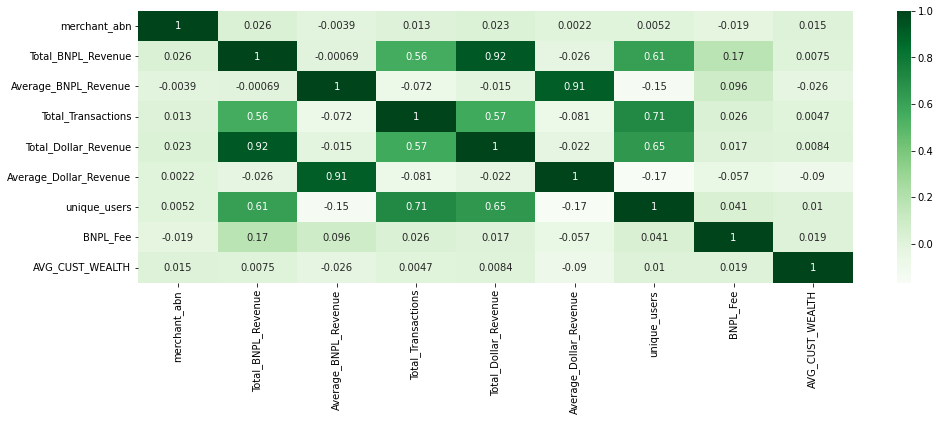

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)